<a href="https://colab.research.google.com/github/SureshAanjana/SENTIMENT-ANALYSIS-OF-AMAZON-ALEXA-REVIEWS-USING-MACHINE-LEARNING/blob/main/Amazon_Alexa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
%pip install wordcloud


## EDA

In [3]:
data = pd.read_csv(r"amazon_alexa.tsv", delimiter = '\t', quoting = 3)

In [4]:
data.shape

(3150, 5)

In [5]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [6]:
print(f"feature names : {data.columns.values}")

feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [7]:
# check for null values
data.isna().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [8]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [9]:
data.dropna(inplace=True)

In [10]:
data.shape

(3149, 5)

In [11]:
# creating a new coloumn length that will contain the length of string of verified reviews
data['length']=data['verified_reviews'].apply(lambda x:len(x))

In [12]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [13]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


## analyzing the rating coloumn

In [14]:
#analyze the rating coloumn
data['rating'].value_counts()

,count
rating,
5,2286
4,455
1,161
3,152
2,95


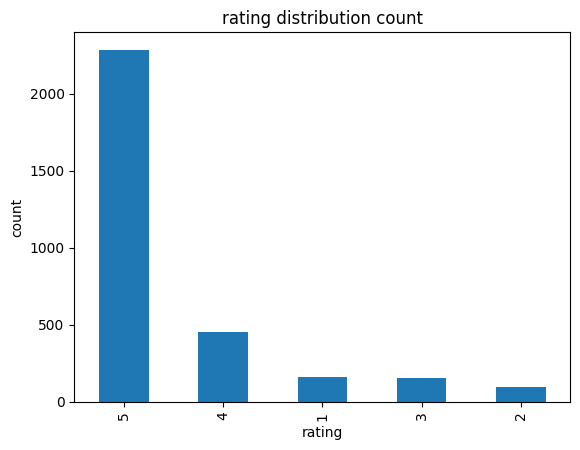

In [15]:
data['rating'].value_counts().plot(kind='bar')
plt.title('rating distribution count')
plt.xlabel('rating')
plt.ylabel('count')
plt.show()

In [16]:
#finding percentage distribution of each rating this can be achieved by dividing the specific rating count by total number of rows
print(f"percentage vise distribution of rating :\n {data['rating'].value_counts()/len(data)*100}")

percentage vise distribution of rating :
 rating
5    72.594474
4    14.449031
1     5.112734
3     4.826929
2     3.016831
Name: count, dtype: float64


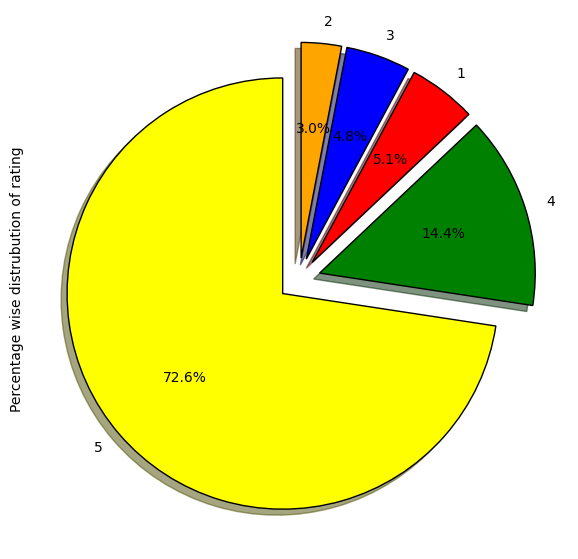

In [17]:
fig =plt.figure(figsize=(7,7))
colors={'red','green','blue','orange','yellow'}
wp={'linewidth':1,'edgecolor':'black'}
tags=data['rating'].value_counts()/len(data)
explode=(0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True,startangle=90,colors=colors ,wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')
from io import  BytesIO
graph = BytesIO()
fig.savefig(graph, format="png")


## Analyzing feedback column

In [18]:
#look for different values of feedback and their count
data['feedback'].value_counts()

,count
feedback,
1,2893
0,256


there are two different values of feedback let see what type of review they corroponds to (0,1)

In [19]:
# looking for the verified review associated with the feedback equals to 1
data[data['feedback']==1].iloc[1]['verified_reviews']

'Loved it!'

In [20]:
# looking for the verified review associated with the feedback equals to 0
data[data['feedback']==0].iloc[1]['verified_reviews']

'Sound is terrible if u want good music too get a bose'

from the above observation it is clear that 1 is positive review and 2 is negative review

lets plot a feedback value count in a bar plot

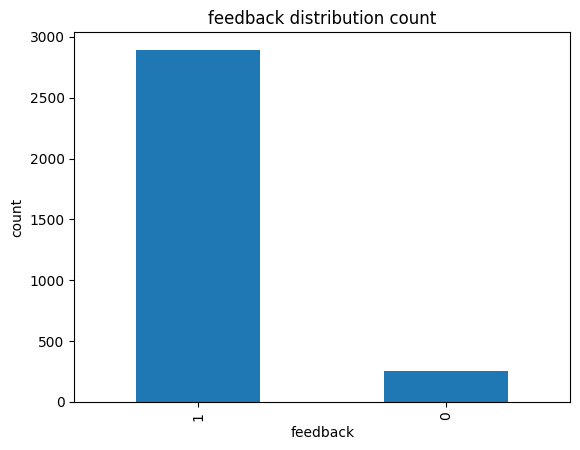

In [21]:
data['feedback'].value_counts().plot(kind='bar')
plt.title('feedback distribution count')
plt.xlabel('feedback')
plt.ylabel('count')
plt.show()


In [22]:
# finding the percentage distribution of each feedback count
print(f"percentage vise distribution of feedback :\n {round(data['feedback'].value_counts()/len(data)*100,2)}")

percentage vise distribution of feedback :
 feedback
1    91.87
0     8.13
Name: count, dtype: float64


this tells that

+ positive feedback - 92%
+ negative feedback - 8%

<Axes: ylabel='Percentage wise distrubution of feedback'>

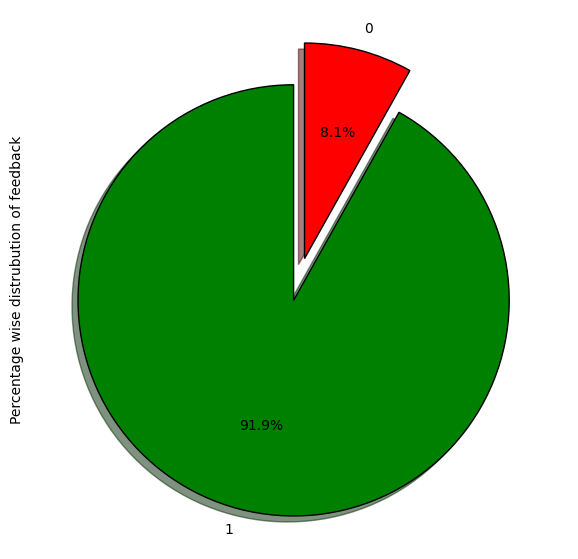

In [23]:
fig=plt.figure(figsize=(7,7))
colors={'red','green'}
wp={'linewidth':1,'edgecolor':'black'}
tags=data['feedback'].value_counts()/len(data)
explode=(0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')


let see different values rating for different values of feedback


In [24]:
data[data['feedback']==0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [25]:
data[data['feedback']==1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


this concludes that
+ if the rating is 1 or 2 feedback is negative(0)
+ if rating is 3, 4 or 5 then feedback is positive(1)

## Analyze variation coloumn
this coloumn refers to the variation or type of amazon alexa project. Example - Black Dot, charcoal fabric , white

In [26]:
print(f"variation value count:\n{data['variation'].value_counts()}")

variation value count:
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


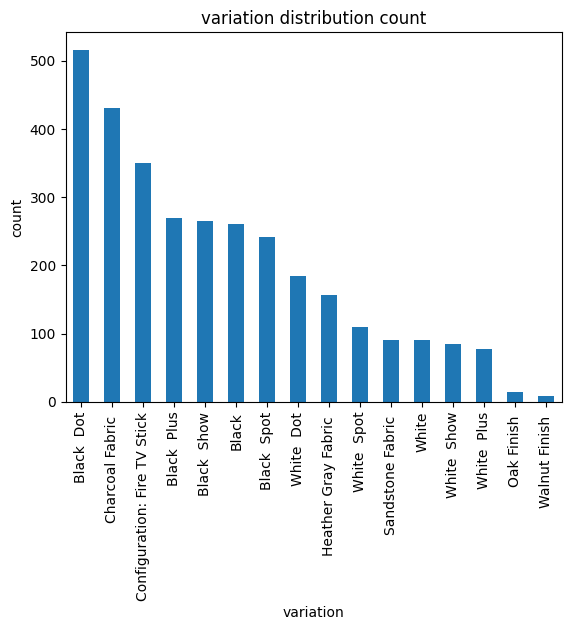

In [27]:
#bar graph to visualize the total count of each variation
data['variation'].value_counts().plot(kind='bar')
plt.title('variation distribution count')
plt.xlabel('variation')
plt.ylabel('count')
plt.show()


In [28]:
#finding percentage distribution of each variation
print(f"percentage vise distribution of variation :\n {round(data['variation'].value_counts()/len(data)*100,2)}")

percentage vise distribution of variation :
 variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


mean rating of every variation

In [29]:
#groupby data on the basis of variation and then find the mean of rating for every variation
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


lets analyze the above provided rating

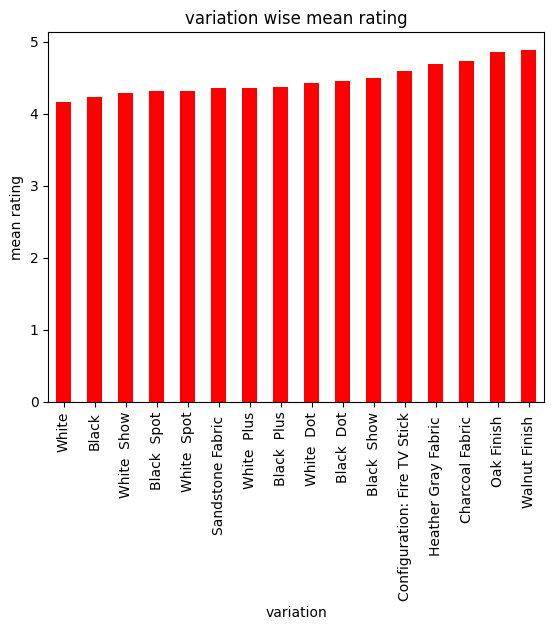

In [30]:
data.groupby('variation')['rating'].mean().sort_values().plot(kind='bar',color='red')
plt.title('variation wise mean rating')
plt.xlabel('variation')
plt.ylabel('mean rating')
plt.show()

## analyze verified_review coloumn
this column contain the textual review given by the user for a variation for the product

In [31]:
data.length.describe()

,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


[Text(0.5, 1.0, 'distribution of length of verified reviews')]

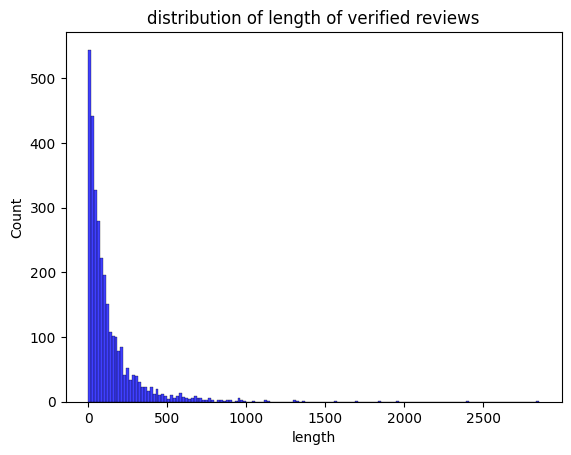

In [32]:
sns.histplot(data['length'],color='blue').set(title='distribution of length of verified reviews')

length analysis when feedback is zero(negative)

[Text(0.5, 1.0, 'distribution of length of verified reviews')]

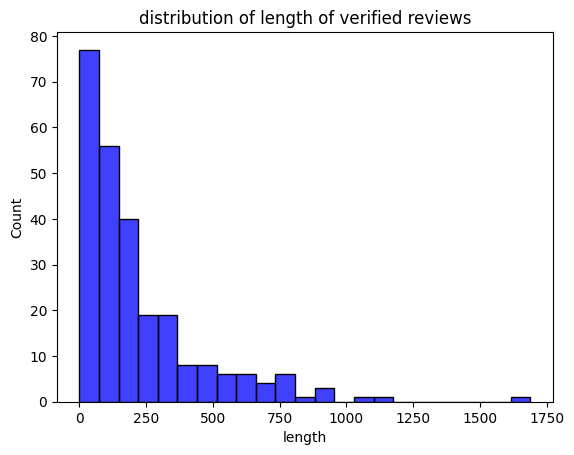

In [33]:
sns.histplot(data[data['feedback']==0].length,color='blue').set(title='distribution of length of verified reviews')

length analysis when feedback is one(positive)

[Text(0.5, 1.0, 'distribution of length of verified reviews')]

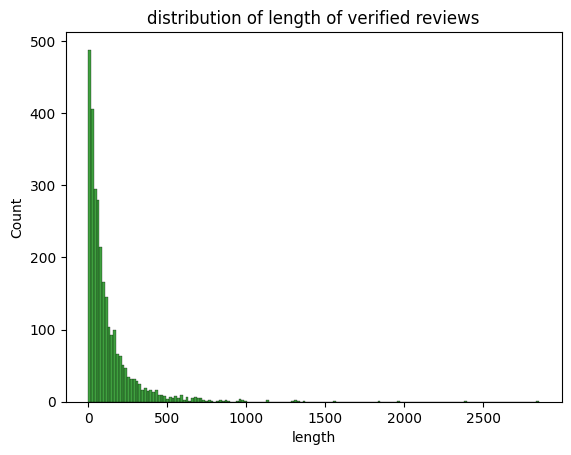

In [34]:
sns.histplot(data[data['feedback']==1].length,color='green').set(title='distribution of length of verified reviews')

length wise mean rating

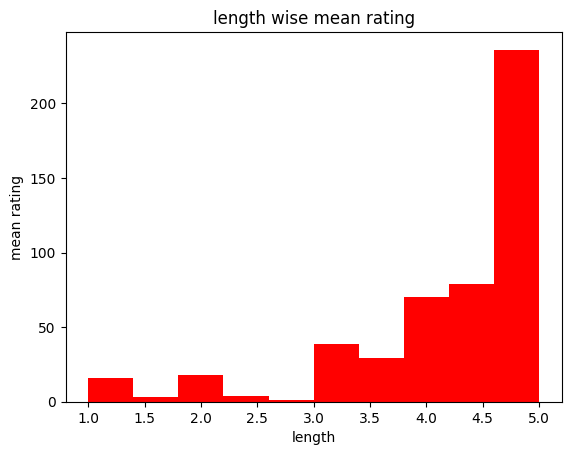

In [35]:
data.groupby('length')['rating'].mean().plot(kind='hist',color='red')
plt.title('length wise mean rating')
plt.xlabel('length')
plt.ylabel('mean rating')
plt.show()

In [36]:
cv=CountVectorizer(stop_words='english')
words=cv.fit_transform(data['verified_reviews'])

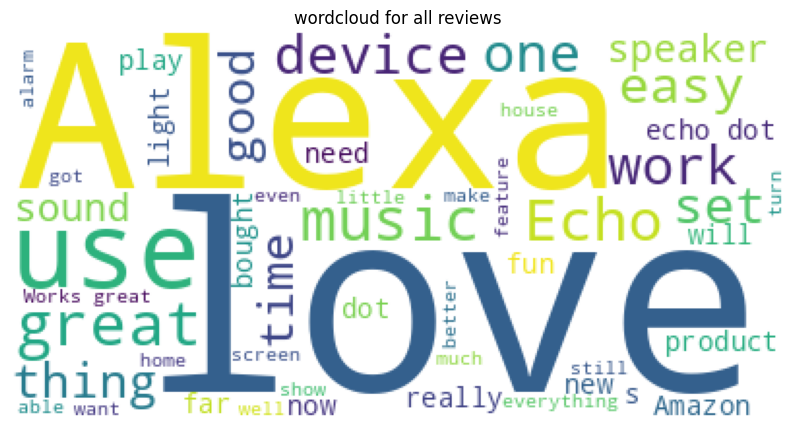

In [37]:
#combine all review
reviews=" ".join([review for review in data['verified_reviews']])

#initialize wordcloud object
wc=WordCloud(background_color='white',max_words=50)

#generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('wordcloud for all reviews')
plt.axis('off')
plt.show()

### lets find the unique words in each feedback category

In [38]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)



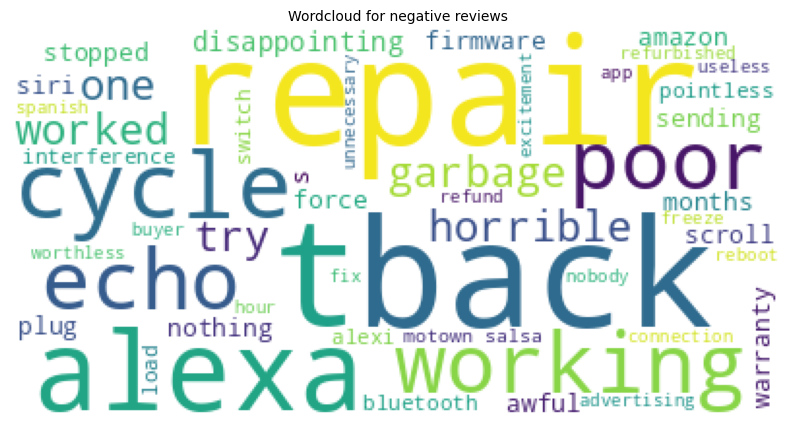

In [39]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

here we observe that some of the unique words are : alexa,back,cycle, echo, repair, working

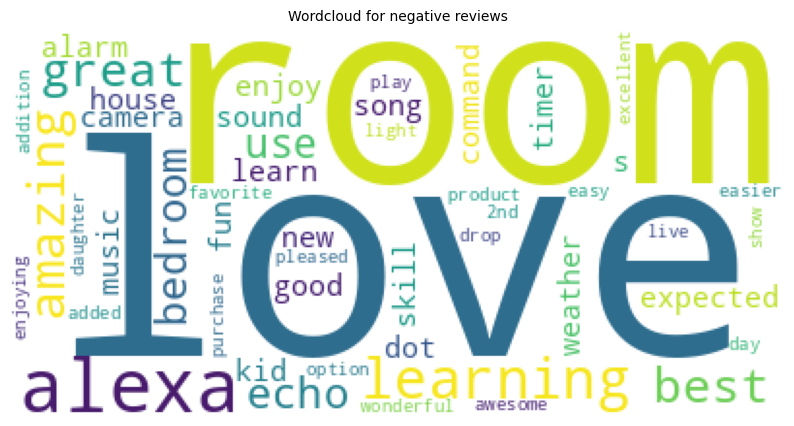

In [40]:
wc=WordCloud(background_color='white',max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

positive words can be seen in the above words are: amazing, room, love, learning, alexa, great

## preprocessing and modelling
To build the corpus from the verified_reviews we perfrom the following-

1. replace any nonalphabet characters with a space
2. convert into lower case and split into words
3. iterate over individual words and if it is not a stopword then add the stemmed form of the word to the corpus


In [41]:
corpus= []
stemmer=PorterStemmer()
for i in range (0,len(data)):
    review=re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review=review.lower().split()
    review=[stemmer.stem(word) for word in review if word not in STOPWORDS]
    review=' '.join(review)
    corpus.append(review)


using count vectorizer to create a bag of words

In [42]:
cv=CountVectorizer(max_features=2500)

# storing dependent and independent variable in X and Y
X=cv.fit_transform(corpus).toarray()
y=data['feedback'].values


In [43]:
# saving the count vectorizer model
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))


In [44]:
# checking the shape of X and Y
print(X.shape,y.shape)

(3149, 2500) (3149,)


split the data into train and test data set with 30% of the data for the testing purpose

In [45]:
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=15)

print(f"x_train : {x_train.shape}")
print(f"x_test : {x_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

x_train : (2204, 2500)
x_test : (945, 2500)
y_train : (2204,)
y_test : (945,)


we will scale x_train, x_test so that all the values are between 0 and 1

In [46]:
scaler= MinMaxScaler()
x_train_scl=scaler.fit_transform(x_train)
x_test_scl=scaler.fit_transform(x_test)

In [47]:
#saving the scaler model
pickle.dump(scaler, open('scaler.pkl', 'wb'))

## random forest

In [48]:
#applying random forest model
model_rf=RandomForestClassifier()
model_rf.fit(x_train_scl,y_train)

RandomForestClassifier()

In [49]:
model_rf.score(x_test_scl,y_test)

0.944973544973545

In [50]:
# predicting on the test set
y_preds=model_rf.predict(x_test_scl)

In [51]:
#confusion matrix
cm=confusion_matrix(y_test,y_preds)

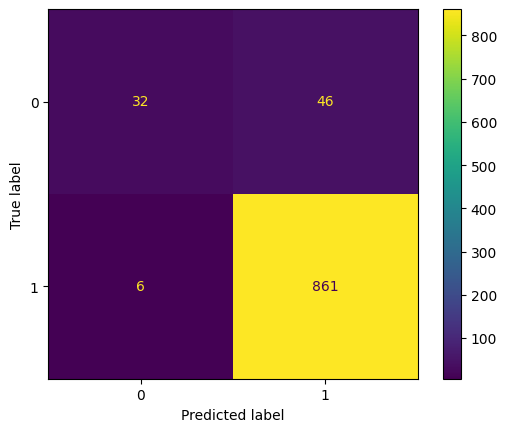

In [52]:
cm_display= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

k-fold cross val score

In [54]:
accuracies=cross_val_score(estimator=model_rf,X=x_train_scl,y=y_train,cv=10)
print("Accuracy:", accuracies.mean())
print("Standard deviation:",accuracies.std())

Accuracy: 0.9333031674208143
Standard deviation: 0.007611581107873934


applyig grid search cv on random forest to get optimal number of parameters

In [55]:
params={
    'bootstrap':[True],
    'max_depth':[80,100],
    'min_samples_split':[8,10],
    'n_estimators':[100,300]
}

In [57]:
cv_object=StratifiedKFold(n_splits=2)
grid_search=GridSearchCV(estimator=model_rf,param_grid=params,cv=cv_object,verbose=0,return_train_score=True)
grid_search.fit(x_train_scl,y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 10],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [58]:
#getting the best parameter from grid search cv
print("Best parameter combination:",grid_search.best_params_)

Best parameter combination: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 10, 'n_estimators': 300}


In [59]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.89768602540835
Cross validation mean accuracy on test set : 92.13362068965517
Accuracy score for test set : 0.944973544973545


In [63]:
# Install the necessary libraries
!pip install scikit-learn==1.5.2
!pip install xgboost
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 51.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


### XG boost algorithm

In [64]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train_scl, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [67]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_xgb.score(x_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(x_test_scl, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9343915343915344


In [68]:
y_preds=model_xgb.predict(x_test_scl)

In [69]:
cm=confusion_matrix(y_test,y_preds)
print(cm)


[[ 27  51]
 [ 11 856]]


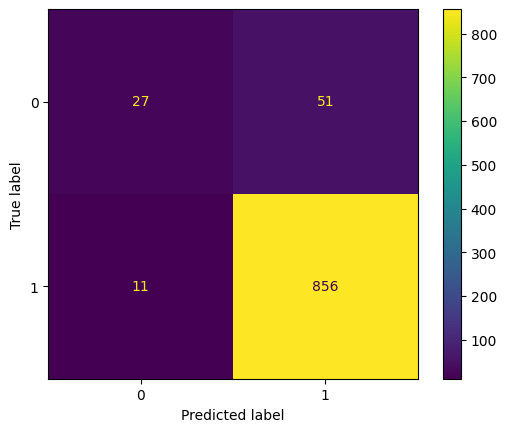

In [71]:
cm_display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [72]:
#saving the XGBoost classifier
pickle.dump(model_xgb,open('xgboost.pkl','wb'))